In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler , StandardScaler
import pickle

In [269]:
df_feat = pd.read_csv('../encoded data/opamps-features.csv')
df_ref = pd.read_csv('../encoded data/opamps-xref.csv')

In [270]:
numerical_columns = ["Maximum Input Offset Voltage","Maximum Single Supply Voltage","Minimum Single Supply Voltage","Number of Channels per Chip","Typical Gain Bandwidth Product"]
scaler = StandardScaler()
df_feat[numerical_columns] = scaler.fit_transform(df_feat[numerical_columns] )
df_feat.describe()

,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Typical Gain Bandwidth Product
count,1.835200e+04,1.835200e+04,1.835200e+04,1.835200e+04,18352.000000
mean,-2.516635e-18,5.575314e-17,-1.858438e-16,-1.146037e-16,0.000000
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027
min,-8.615120e-02,-1.154568e+00,-1.663955e+00,-1.000045e+00,-0.182770
25%,-7.454549e-02,-9.178854e-01,-5.187697e-01,-1.000045e+00,-0.179285
50%,-3.972837e-02,-3.577365e-01,-2.411490e-01,-1.268909e-01,-0.172527
75%,2.990587e-02,1.015023e+00,0.000000e+00,-1.268909e-01,-0.137220
max,9.275950e+01,3.381849e+00,8.989739e+00,1.619417e+00,30.188749


In [271]:
df_stm = df_ref.merge(df_feat , left_on=["STMicro MPN","STMicro Name"], right_on=["MPN",	"MANUFACTURER"	])
df_merged = df_stm.merge(df_feat , left_on=["Competitor MPN","Competitor Name"], right_on=["MPN",	"MANUFACTURER"	], suffixes = ("","_comp") )
df_merged.drop(columns=["STMicro MPN","STMicro Name", "Competitor MPN","Competitor Name"],inplace = True)
df_merged.head()

,Cross Reference Type,MPN,MANUFACTURER,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Supplier_Package,Typical Gain Bandwidth Product,MPN_comp,MANUFACTURER_comp,Maximum Input Offset Voltage_comp,Maximum Single Supply Voltage_comp,Minimum Single Supply Voltage_comp,Number of Channels per Chip_comp,Supplier_Package_comp,Typical Gain Bandwidth Product_comp
0,A,PN-1017594,MN-1030,-0.039728,1.015023,-0.032933,-1.000045,SOT-23,-0.17974,PN-1017599,MN-1036,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974
1,A,PN-1017602,MN-1030,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974,PN-1017598,MN-1036,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974
2,A,PN-1017602,MN-1030,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974,PN-1017597,MN-1036,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974
3,A,PN-1017594,MN-1030,-0.039728,1.015023,-0.032933,-1.000045,SOT-23,-0.17974,PN-1017598,MN-1036,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974
4,A,PN-1017602,MN-1030,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974,PN-1017599,MN-1036,0.006694,1.015023,-0.032933,-1.000045,SOT-23,-0.17974


In [272]:
df_merged.describe()

,Maximum Input Offset Voltage,Maximum Single Supply Voltage,Minimum Single Supply Voltage,Number of Channels per Chip,Typical Gain Bandwidth Product,Maximum Input Offset Voltage_comp,Maximum Single Supply Voltage_comp,Minimum Single Supply Voltage_comp,Number of Channels per Chip_comp,Typical Gain Bandwidth Product_comp
count,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06,1.004847e+06
mean,-8.320233e-03,-1.371419e-01,-3.478263e-01,5.589719e-02,-1.643223e-01,-2.304514e-03,-4.162519e-01,-2.352240e-01,5.634817e-02,-4.551266e-02
std,1.095308e-01,9.471591e-01,5.382457e-01,9.566776e-01,3.260528e-02,9.160675e-01,8.526709e-01,7.883929e-01,9.567971e-01,7.934808e-01
min,-8.603514e-02,-9.178854e-01,-1.074011e+00,-1.000045e+00,-1.827433e-01,-8.615120e-02,-1.154568e+00,-1.663955e+00,-1.000045e+00,-1.827698e-01
25%,-6.642150e-02,-9.178854e-01,-8.657955e-01,-1.000045e+00,-1.789810e-01,-7.512578e-02,-9.178854e-01,-7.269852e-01,-1.000045e+00,-1.789810e-01
50%,-1.651696e-02,-8.784383e-01,-2.411490e-01,-1.268909e-01,-1.778421e-01,-3.508609e-02,-9.178854e-01,-2.411490e-01,-1.268909e-01,-1.721474e-01
75%,1.830016e-02,1.015023e+00,-3.293346e-02,-1.268909e-01,-1.618970e-01,2.990587e-02,-3.577365e-01,-1.717438e-01,-1.268909e-01,-1.448130e-01
max,1.306534e+00,2.119542e+00,2.049222e+00,1.619417e+00,6.399122e-02,9.275950e+01,3.381849e+00,8.989739e+00,1.619417e+00,3.018875e+01


In [273]:
test  = df_feat.merge(df_feat, on=["MPN",	"MANUFACTURER"],suffixes = ("","_comp"))
test["MPN_comp"]= test["MPN"]
test["MANUFACTURER_comp"]= test["MANUFACTURER"]
test["Cross Reference Type"] = "A"
test = test.reindex(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp'],axis=1)
test['Cross Reference Type'].value_counts()

Cross Reference Type
A    18352
Name: count, dtype: int64

In [274]:
df_merged = pd.concat([df_merged,test])
df_merged["Cross Reference Type"].value_counts()

Cross Reference Type
D              808455
C              158650
B               36764
A               18360
C/Upgrade         465
C/Downgrade       336
B/Downgrade       114
B/Upgrade          48
SF                  7
Name: count, dtype: int64

In [275]:
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("B/Downgrade","B")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("B/Upgrade","B")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("C/Downgrade","C")
df_merged["Cross Reference Type"] = df_merged["Cross Reference Type"].replace("C/Upgrade","C")

In [276]:
df_merged["Cross Reference Type"].value_counts()
df_filtered = df_merged[~df_merged["Cross Reference Type"].isin(["SF"])] # à rectifier avec l'equipe de données
df_filtered["Cross Reference Type"].value_counts()

Cross Reference Type
D    808455
C    159451
B     36926
A     18360
Name: count, dtype: int64

In [192]:
len(df_filtered)

1023192

In [267]:
df_filtered.to_csv('df_filtered.csv', index=False)

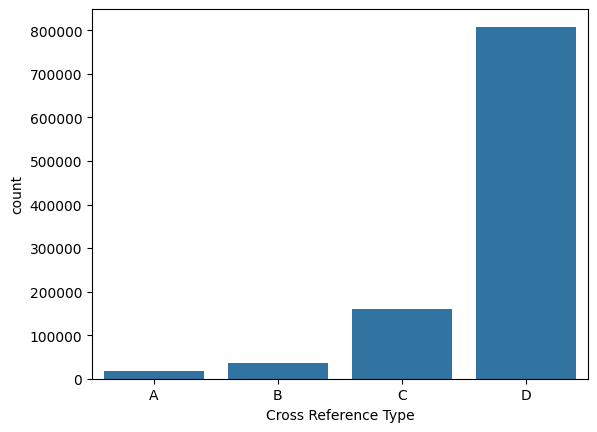

In [277]:
sns.countplot(df_filtered, x="Cross Reference Type")
plt.show()

In [181]:
from sklearn.model_selection import train_test_split
def split_dataframe(df, train_percent=0.8, validate_percent=0.1, test_percent=0.1, random_state=42, stratify_col="Cross Reference Type"):
    assert train_percent + validate_percent + test_percent == 1, "Split percentages must sum to 1."

    # First split: Train and Temp (Validate + Test)
    train_df, temp_df = train_test_split(
        df,
        test_size=(validate_percent + test_percent),
        stratify=df[stratify_col],
        random_state=random_state
    )
    
    # Calculate the proportion of validation and test from the Temp split
    if validate_percent==0:
        return train_df,pd.DataFrame(columns=df.columns), temp_df
    test_size = test_percent / (validate_percent + test_percent)
    
    # Second split: Validate and Test
    validate_df, test_df = train_test_split(
        temp_df,
        test_size=test_size,
        stratify=temp_df[stratify_col],
        random_state=random_state
    )
    
    return train_df, validate_df, test_df

In [282]:
train_df, validate_df, test_df = split_dataframe(df_sampled)
print(train_df["Cross Reference Type"].value_counts(normalize=True))
print(validate_df["Cross Reference Type"].value_counts(normalize=True))
print(test_df["Cross Reference Type"].value_counts(normalize=True))

Cross Reference Type
A    0.25
D    0.25
C    0.25
B    0.25
Name: proportion, dtype: float64
Cross Reference Type
A    0.25
B    0.25
D    0.25
C    0.25
Name: proportion, dtype: float64
Cross Reference Type
D    0.25
A    0.25
C    0.25
B    0.25
Name: proportion, dtype: float64


In [278]:
class_A = train_df[train_df["Cross Reference Type"] == "A"]
class_B = train_df[train_df["Cross Reference Type"].isin(["B"])]
class_C = train_df[train_df["Cross Reference Type"].isin(["C"])]
class_D = train_df[train_df["Cross Reference Type"].isin(["D"])]
#n= 36926
n= 100000
random_state = 42


In [279]:
class_B_downsampled = class_B.sample(n=n, random_state=random_state,replace=True)
class_C_downsampled = class_C.sample(n=n,random_state=random_state)
class_A_oversampled = class_A.sample(n=n,random_state=random_state, replace= True)
class_D_downsampled = class_D.sample(n=n,random_state=random_state)

In [280]:
df_sampled = pd.concat([class_A_oversampled, class_B_downsampled, class_C_downsampled,class_D_downsampled],axis=  0)

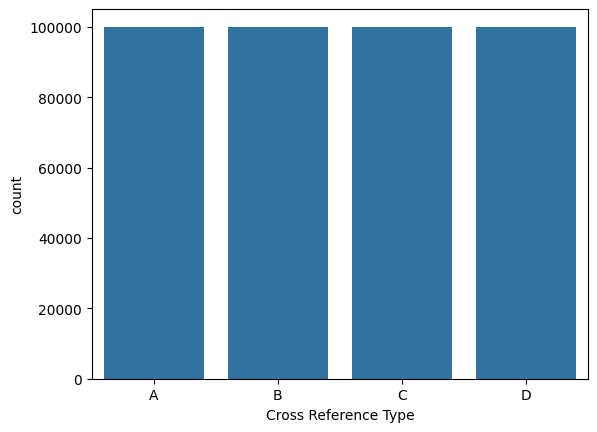

In [281]:
sns.countplot(df_sampled, x="Cross Reference Type")
plt.show()

In [283]:

from scipy.stats import norm
def convert(df_sampled):
    base_means = {
        'A': 0.96,
        'B': 0.84,
    # 'C': 0.71,
    'C': 0.65,
        #'D':0.59 # 0.55, 0.65
        'D':0.5
    }
    base_std={
        'A': 0.0107,
        'B': 0.0249,
        'C': 0.01779,
        'D': 0.01779
    }
    interval= {
        "A":(0.93,1),
        "B": (0.77,0.92),
        #"C":(0.66,0.76),
        "C":(0.60,0.71),
        #"D":(0.55,0.65)
        "D":(0.44,0.56)
    }
    def get_params(category):
        parts = category.split('/')
        
        mean = base_means.get(parts[0], 0.0)
        std = base_std.get(parts[0], 0.0)
        return mean, std
    df_sampled["Mean"] , df_sampled["Std"] = zip(*df_sampled["Cross Reference Type"].map(get_params))
    df_sampled['Closeness'] = df_sampled.apply(lambda row: norm.rvs(loc=row['Mean'], scale=row['Std']), axis=1)
    df_sampled['Closeness'] = df_sampled['Closeness'].clip(0, 1)
    for classe in interval:
        df_sampled.loc[df_sampled["Cross Reference Type"]==classe, "Closeness"] = df_sampled.loc[df_sampled["Cross Reference Type"]==classe, "Closeness"].clip(*interval[classe])
convert(train_df)
convert(validate_df)
convert(test_df)


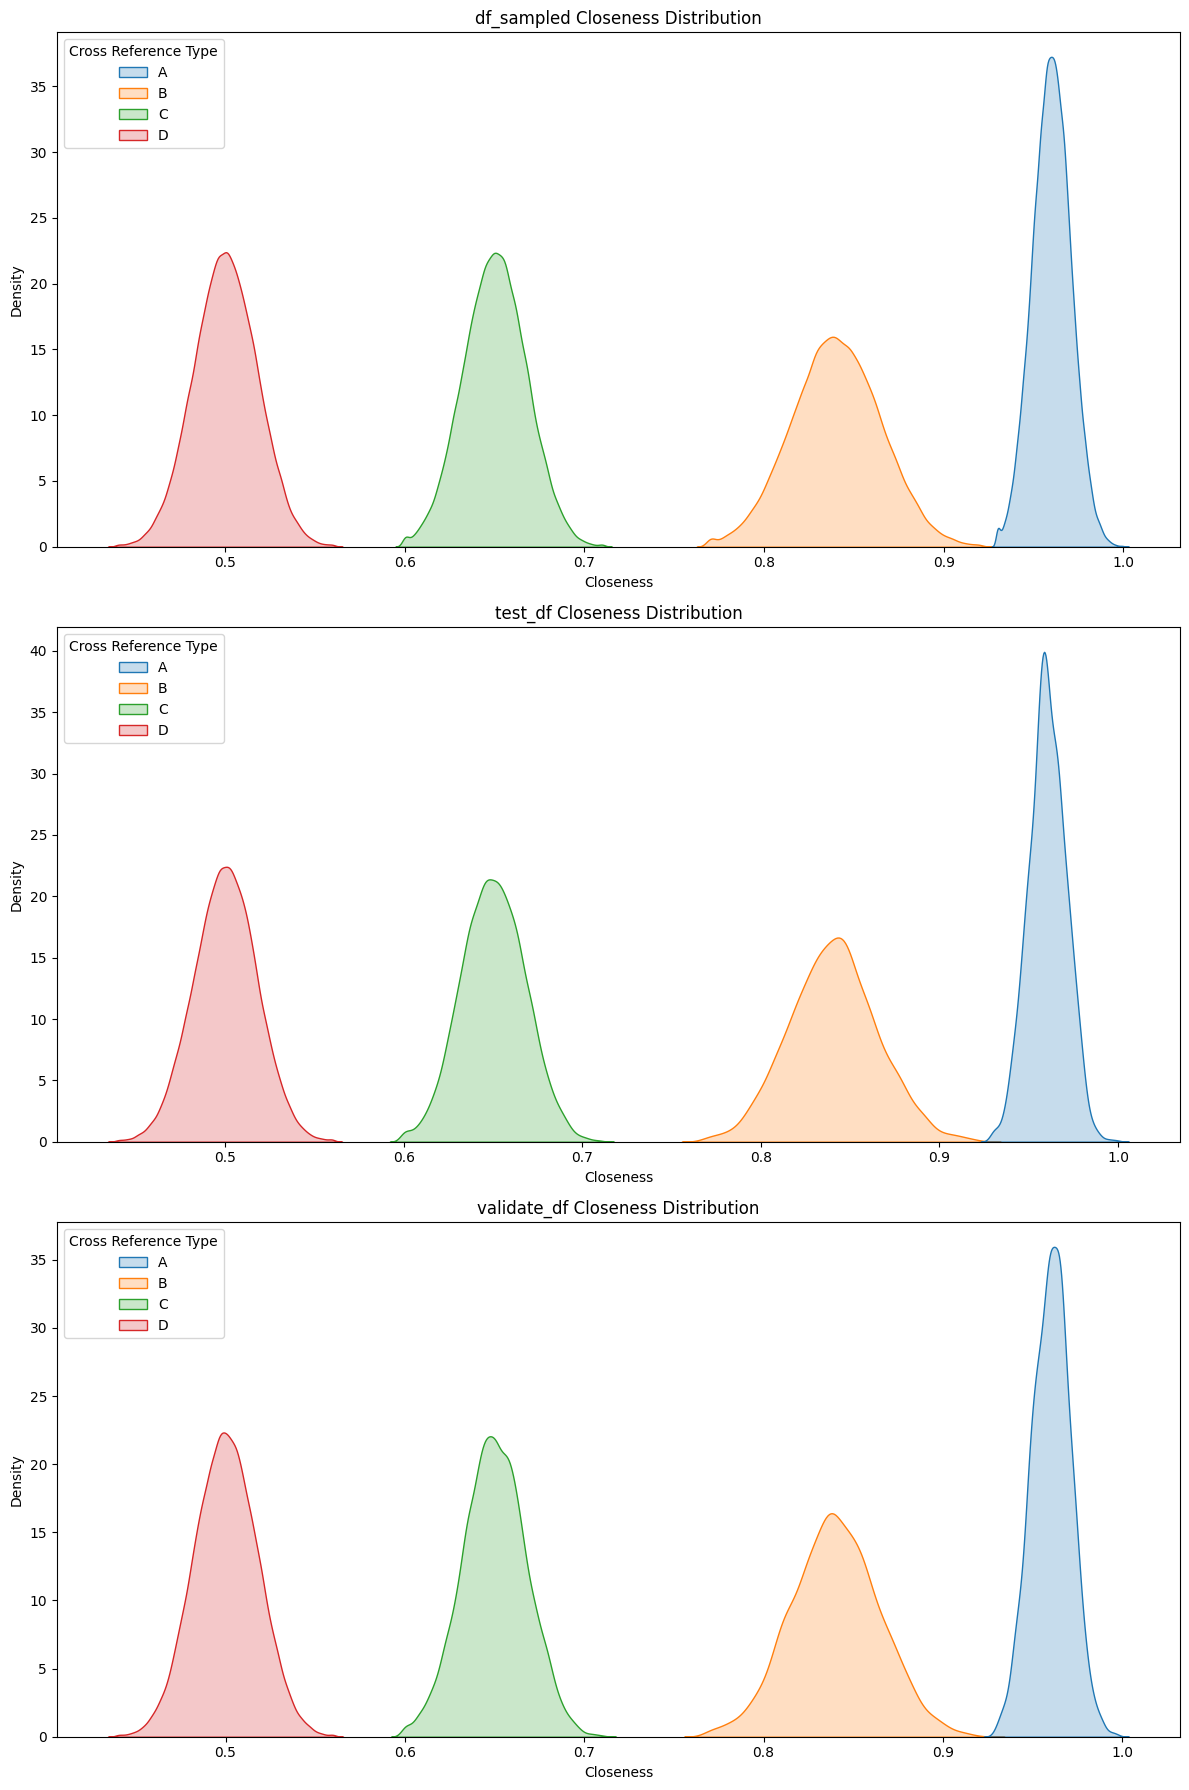

In [260]:
# Define a color palette


# Plot KDE plots with the same color palette
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.kdeplot(data=train_df.sort_values("Cross Reference Type"), x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False, ax=axes[0])
axes[0].set_title('df_sampled Closeness Distribution')

sns.kdeplot(data=test_df.sort_values("Cross Reference Type"), x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False, ax=axes[1])
axes[1].set_title('test_df Closeness Distribution')

sns.kdeplot(data=validate_df.sort_values("Cross Reference Type"), x='Closeness', hue='Cross Reference Type', fill=True, common_norm=False, ax=axes[2])
axes[2].set_title('validate_df Closeness Distribution')

plt.tight_layout()
plt.show()


In [188]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1023192 entries, 0 to 18351
Data columns (total 17 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Cross Reference Type                 1023192 non-null  object 
 1   MPN                                  1023192 non-null  object 
 2   MANUFACTURER                         1023192 non-null  object 
 3   Maximum Input Offset Voltage         1023192 non-null  float64
 4   Maximum Single Supply Voltage        1023192 non-null  float64
 5   Minimum Single Supply Voltage        1023192 non-null  float64
 6   Number of Channels per Chip          1023192 non-null  float64
 7   Supplier_Package                     1023192 non-null  object 
 8   Typical Gain Bandwidth Product       1023192 non-null  float64
 9   MPN_comp                             1023192 non-null  object 
 10  MANUFACTURER_comp                    1023192 non-null  object 
 11  Maxim

In [12]:
df_filtered.columns

Index(['Cross Reference Type', 'MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product', 'MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp', 'Mean', 'Std', 'Closeness'],
      dtype='object')

In [284]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder


In [285]:
class CustomVectorDataset(Dataset):
    def __init__(self, dataframe, vector1_columns, vector2_columns, target_column, categorical_columns=[]):
        """
        Args:
            dataframe (pd.DataFrame): The DataFrame containing the data.
            vector1_columns (list): List of column names for the first vector.
            vector2_columns (list): List of column names for the second vector.
            target_column (str): The column name for the target value.
            categorical_columns (list): List of column names that are categorical.
        """
        self.dataframe = dataframe.copy()
        self.vector1_columns = vector1_columns
        self.vector2_columns = vector2_columns
        self.target_column = target_column
        self.categorical_columns = categorical_columns
        
        # Label encode categorical columns
        self.label_encoders = {}
        for col in self.categorical_columns:
            le = LabelEncoder()
            self.dataframe[col] = le.fit_transform(self.dataframe[col])
            self.label_encoders[col] = le
        
        # Convert columns to tensors
        self.vector1 = torch.tensor(self.dataframe[vector1_columns].values, dtype=torch.float32)
        self.vector2 = torch.tensor(self.dataframe[vector2_columns].values, dtype=torch.float32)
        self.target = torch.tensor(self.dataframe[target_column].values, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        vector1 = self.vector1[idx]
        vector2 = self.vector2[idx]
        target = self.target[idx]
        return vector1, vector2, target

In [286]:
columns_1 = ['MPN', 'MANUFACTURER',
       'Maximum Input Offset Voltage', 'Maximum Single Supply Voltage',
       'Minimum Single Supply Voltage', 'Number of Channels per Chip',
       'Supplier_Package', 'Typical Gain Bandwidth Product']
columns_2 = ['MPN_comp',
       'MANUFACTURER_comp', 'Maximum Input Offset Voltage_comp',
       'Maximum Single Supply Voltage_comp',
       'Minimum Single Supply Voltage_comp',
       'Number of Channels per Chip_comp', 'Supplier_Package_comp',
       'Typical Gain Bandwidth Product_comp']
categorical_columns=['MPN', 'MANUFACTURER','Supplier_Package','MPN_comp',
       'MANUFACTURER_comp','Supplier_Package_comp']

In [92]:
# from sklearn.model_selection import train_test_split

# # Define the sample size
# sample_size = 0.3  # 10% of the original data

# # Sample the dataframe while maintaining the same proportions of class A, B, C, and D
# df_sampled, _ = train_test_split(df_filtered, test_size=(1 - sample_size), stratify=df_filtered['Cross Reference Type'], random_state=42)

# # Display the sampled dataframe
# df_sampled['Cross Reference Type'].value_counts()

Cross Reference Type
D    242536
C     47835
B     11078
A      5508
Name: count, dtype: int64

In [193]:
# train_df = df_sampled

In [287]:
len(train_df), len(validate_df), len(test_df)

(320000, 40000, 40000)

In [288]:
batch_size = 32

In [289]:
torch.manual_seed(42)
dataset_train = CustomVectorDataset(train_df,columns_1,columns_2, 'Closeness',categorical_columns=categorical_columns)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
# Test
dataset_test = CustomVectorDataset(test_df, columns_1, columns_2, 'Closeness', categorical_columns=categorical_columns)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
# Validation
dataset_validate = CustomVectorDataset(validate_df, columns_1, columns_2, 'Closeness', categorical_columns=categorical_columns)
dataloader_validate = DataLoader(dataset_validate, batch_size=batch_size, shuffle=False)

In [290]:

"Different poids pour chaque classe"
# class SiameseNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(SiameseNetwork, self).__init__()
#         # Feature extractor 1
#         self.extract_features_1 = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU()
#         )
#         # Feature extractor 2
#         self.extract_features_2 = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU()
#         )
#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1)  # Output layer for regression
#         )

#     def forward(self, input1, input2):
#         output1 = self.extract_features_1(input1)
#         output2 = self.extract_features_2(input2)
#         # Concatenate feature vectors from both inputs
#         combined = torch.cat((output1, output2), dim=1)
#         closeness = self.fc(combined)
#         return closeness
"meme poids pour chaque classe"
# class SiameseNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(SiameseNetwork, self).__init__()
#         # Shared Feature Extractor
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ELU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ELU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ELU()
#         )
#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.ELU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ELU(),
#             nn.Dropout(0.2),
#             nn.Linear(32, 16),
#             nn.ELU(),
#             nn.Linear(16, 1)  # Output layer for regression
#         )

#     def forward(self, input1, input2):
#         # Apply the shared feature extractor to both inputs
#         output1 = self.feature_extractor(input1)
#         output2 = self.feature_extractor(input2)
#         # Concatenate the features from both inputs
#         combined = torch.cat((output1, output2), dim=1)
#         # Pass the combined features through the fully connected layers
#         closeness = self.fc(combined)
#         return closeness

import torch
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim):
        super(SiameseNetwork, self).__init__()
        
        # Shared Feature Extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )
        
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            
            nn.Linear(32, 1)  # Output Layer for Regression
        )
        
    def forward(self, input1, input2):
        # Extract features for both inputs
        output1 = self.feature_extractor(input1)
        output2 = self.feature_extractor(input2)
        
        # Concatenate the features
        combined = torch.cat((output1, output2), dim=1)
        
        # Pass through fully connected layers
        closeness = self.fc(combined)
        
        return closeness

In [247]:
# class FullyConnected(nn.Module):
#     def __init__(self, input_dim):
#         super(FullyConnected, self).__init__()
#         combined_dim = input_dim * 2
        
#         self.network = nn.Sequential(
#             nn.Linear(combined_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.1),
            
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.1),
            
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
            
            
#             nn.Linear(64, 32),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
            
#             nn.Linear(32, 1)
#         )
        
#     def forward(self, input1, input2):
#         combined = torch.cat((input1, input2), dim=1)
#         output = self.network(combined)
#         return output
class FullyConnected(nn.Module):
    def __init__(self, input_dim):
        super(FullyConnected, self).__init__()
        combined_dim = input_dim * 2
        
        self.network = nn.Sequential(
            nn.Linear(combined_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1)
        )
        
    def forward(self, input1, input2):
        combined = torch.cat((input1, input2), dim=1)
        output = self.network(combined)
        return output

In [291]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Apply the initialization to the model


In [226]:
torch.cuda.is_available()

True

In [292]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [228]:
len(dataloader_train.dataset)

400000

In [248]:
input_dim = len(columns_1)
model = FullyConnected(input_dim).to(device)
model.apply(init_weights)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.1, patience=2, 
                                                 verbose=True)

c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [293]:
from tqdm import tqdm

# Initialize the model, loss function and optimizer
input_dim = len(columns_1)  # Assuming both vectors have the same number of features
model = SiameseNetwork(input_dim).to(device)
model.apply(init_weights)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.1, patience=2, 
                                                 verbose=True)

# Training loop




c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [295]:
num_epochs = 22
train_mse_history = []
val_mse_history = []
test_mse_history = []
for epoch in range(num_epochs):
    # -----------------------------
    # 5.1. Training Phase
    # -----------------------------
    model.train()
    running_loss = 0.0
    for vec1, vec2, target in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(vec1, vec2)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * vec1.size(0)  # Multiply by batch size

    epoch_train_loss = running_loss / len(dataloader_train.dataset)
    train_mse_history.append(epoch_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss (MSE): {epoch_train_loss:.4f}")

    # -----------------------------
    # 5.2. Validation Phase
    # -----------------------------
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for vec1, vec2, target in tqdm(dataloader_validate, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
            output = model(vec1, vec2)
            loss = criterion(output, target)
            val_running_loss += loss.item() * vec1.size(0)  # Multiply by batch size

    epoch_val_loss = val_running_loss / len(dataloader_validate.dataset)
    val_mse_history.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss (MSE): {epoch_val_loss:.4f}")

    # -----------------------------
    # 5.3. Step the Scheduler
    # -----------------------------
    scheduler.step(epoch_val_loss)
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for vec1, vec2, target in tqdm(dataloader_test, desc=f"Epoch {epoch+1}/{num_epochs} - Test"):
            vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
            output = model(vec1, vec2)
            loss = criterion(output, target)
            test_running_loss += loss.item() * vec1.size(0)  # Multiply by batch size

    epoch_val_loss = test_running_loss / len(dataloader_test.dataset)
    test_mse_history.append(epoch_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test  Loss (MSE): {epoch_val_loss:.4f}")
    

# -----------------------------
# 6. Plot Training and Validation MSE
# -----------------------------



Epoch 1/22 - Training: 100%|██████████| 10000/10000 [01:49<00:00, 91.15it/s]


Epoch [1/22], Training Loss (MSE): 0.0228


Epoch 1/22 - Validation: 100%|██████████| 1250/1250 [00:05<00:00, 241.10it/s]


Epoch [1/22], Validation Loss (MSE): 0.0330


Epoch 1/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 234.37it/s]


Epoch [1/22], Test  Loss (MSE): 0.0337


Epoch 2/22 - Training: 100%|██████████| 10000/10000 [01:59<00:00, 83.76it/s]


Epoch [2/22], Training Loss (MSE): 0.0190


Epoch 2/22 - Validation: 100%|██████████| 1250/1250 [00:05<00:00, 219.51it/s]


Epoch [2/22], Validation Loss (MSE): 0.0238


Epoch 2/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 228.56it/s]


Epoch [2/22], Test  Loss (MSE): 0.0251


Epoch 3/22 - Training: 100%|██████████| 10000/10000 [01:44<00:00, 96.03it/s]


Epoch [3/22], Training Loss (MSE): 0.0173


Epoch 3/22 - Validation: 100%|██████████| 1250/1250 [00:04<00:00, 254.55it/s]


Epoch [3/22], Validation Loss (MSE): 0.0246


Epoch 3/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 247.69it/s]


Epoch [3/22], Test  Loss (MSE): 0.0267


Epoch 4/22 - Training: 100%|██████████| 10000/10000 [01:44<00:00, 95.94it/s] 


Epoch [4/22], Training Loss (MSE): 0.0164


Epoch 4/22 - Validation: 100%|██████████| 1250/1250 [00:04<00:00, 300.74it/s]


Epoch [4/22], Validation Loss (MSE): 0.0206


Epoch 4/22 - Test: 100%|██████████| 1250/1250 [00:04<00:00, 294.69it/s]


Epoch [4/22], Test  Loss (MSE): 0.0224


Epoch 5/22 - Training: 100%|██████████| 10000/10000 [01:44<00:00, 95.78it/s]


Epoch [5/22], Training Loss (MSE): 0.0153


Epoch 5/22 - Validation: 100%|██████████| 1250/1250 [00:04<00:00, 284.31it/s]


Epoch [5/22], Validation Loss (MSE): 0.0201


Epoch 5/22 - Test: 100%|██████████| 1250/1250 [00:04<00:00, 301.80it/s]


Epoch [5/22], Test  Loss (MSE): 0.0215


Epoch 6/22 - Training: 100%|██████████| 10000/10000 [01:49<00:00, 91.48it/s]


Epoch [6/22], Training Loss (MSE): 0.0139


Epoch 6/22 - Validation: 100%|██████████| 1250/1250 [00:05<00:00, 233.35it/s]


Epoch [6/22], Validation Loss (MSE): 0.0163


Epoch 6/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 231.89it/s]


Epoch [6/22], Test  Loss (MSE): 0.0190


Epoch 7/22 - Training: 100%|██████████| 10000/10000 [01:57<00:00, 84.86it/s]


Epoch [7/22], Training Loss (MSE): 0.0128


Epoch 7/22 - Validation: 100%|██████████| 1250/1250 [00:05<00:00, 227.94it/s]


Epoch [7/22], Validation Loss (MSE): 0.0149


Epoch 7/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 221.72it/s]


Epoch [7/22], Test  Loss (MSE): 0.0172


Epoch 8/22 - Training: 100%|██████████| 10000/10000 [01:50<00:00, 90.14it/s]


Epoch [8/22], Training Loss (MSE): 0.0123


Epoch 8/22 - Validation: 100%|██████████| 1250/1250 [00:04<00:00, 276.17it/s]


Epoch [8/22], Validation Loss (MSE): 0.0174


Epoch 8/22 - Test: 100%|██████████| 1250/1250 [00:04<00:00, 276.06it/s]


Epoch [8/22], Test  Loss (MSE): 0.0190


Epoch 9/22 - Training: 100%|██████████| 10000/10000 [01:48<00:00, 92.32it/s]


Epoch [9/22], Training Loss (MSE): 0.0120


Epoch 9/22 - Validation: 100%|██████████| 1250/1250 [00:05<00:00, 238.59it/s]


Epoch [9/22], Validation Loss (MSE): 0.0173


Epoch 9/22 - Test: 100%|██████████| 1250/1250 [00:05<00:00, 233.68it/s]


Epoch [9/22], Test  Loss (MSE): 0.0200


Epoch 10/22 - Training: 100%|██████████| 10000/10000 [01:31<00:00, 109.14it/s]


Epoch [10/22], Training Loss (MSE): 0.0118


Epoch 10/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 359.38it/s]


Epoch [10/22], Validation Loss (MSE): 0.0174


Epoch 10/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 356.20it/s]


Epoch [10/22], Test  Loss (MSE): 0.0196


Epoch 11/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 118.06it/s]


Epoch [11/22], Training Loss (MSE): 0.0111


Epoch 11/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 344.75it/s]


Epoch [11/22], Validation Loss (MSE): 0.0152


Epoch 11/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 343.05it/s]


Epoch [11/22], Test  Loss (MSE): 0.0186


Epoch 12/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 117.67it/s]


Epoch [12/22], Training Loss (MSE): 0.0109


Epoch 12/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 335.29it/s]


Epoch [12/22], Validation Loss (MSE): 0.0150


Epoch 12/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 352.99it/s]


Epoch [12/22], Test  Loss (MSE): 0.0183


Epoch 13/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 117.74it/s]


Epoch [13/22], Training Loss (MSE): 0.0108


Epoch 13/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 360.03it/s]


Epoch [13/22], Validation Loss (MSE): 0.0149


Epoch 13/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 348.57it/s]


Epoch [13/22], Test  Loss (MSE): 0.0177


Epoch 14/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 118.03it/s]


Epoch [14/22], Training Loss (MSE): 0.0108


Epoch 14/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 341.61it/s]


Epoch [14/22], Validation Loss (MSE): 0.0152


Epoch 14/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 347.55it/s]


Epoch [14/22], Test  Loss (MSE): 0.0179


Epoch 15/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 118.19it/s]


Epoch [15/22], Training Loss (MSE): 0.0107


Epoch 15/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 350.48it/s]


Epoch [15/22], Validation Loss (MSE): 0.0154


Epoch 15/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 360.51it/s]


Epoch [15/22], Test  Loss (MSE): 0.0185


Epoch 16/22 - Training: 100%|██████████| 10000/10000 [01:24<00:00, 118.63it/s]


Epoch [16/22], Training Loss (MSE): 0.0106


Epoch 16/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 332.21it/s]


Epoch [16/22], Validation Loss (MSE): 0.0151


Epoch 16/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 354.04it/s]


Epoch [16/22], Test  Loss (MSE): 0.0178


Epoch 17/22 - Training: 100%|██████████| 10000/10000 [01:28<00:00, 113.04it/s]


Epoch [17/22], Training Loss (MSE): 0.0106


Epoch 17/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 320.31it/s]


Epoch [17/22], Validation Loss (MSE): 0.0162


Epoch 17/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 334.86it/s]


Epoch [17/22], Test  Loss (MSE): 0.0190


Epoch 18/22 - Training: 100%|██████████| 10000/10000 [01:37<00:00, 102.92it/s]


Epoch [18/22], Training Loss (MSE): 0.0105


Epoch 18/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 334.97it/s]


Epoch [18/22], Validation Loss (MSE): 0.0156


Epoch 18/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 336.58it/s]


Epoch [18/22], Test  Loss (MSE): 0.0186


Epoch 19/22 - Training: 100%|██████████| 10000/10000 [01:37<00:00, 103.08it/s]


Epoch [19/22], Training Loss (MSE): 0.0106


Epoch 19/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 331.74it/s]


Epoch [19/22], Validation Loss (MSE): 0.0160


Epoch 19/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 331.94it/s]


Epoch [19/22], Test  Loss (MSE): 0.0189


Epoch 20/22 - Training: 100%|██████████| 10000/10000 [01:37<00:00, 102.56it/s]


Epoch [20/22], Training Loss (MSE): 0.0105


Epoch 20/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 335.90it/s]


Epoch [20/22], Validation Loss (MSE): 0.0159


Epoch 20/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 334.79it/s]


Epoch [20/22], Test  Loss (MSE): 0.0186


Epoch 21/22 - Training: 100%|██████████| 10000/10000 [01:37<00:00, 102.27it/s]


Epoch [21/22], Training Loss (MSE): 0.0106


Epoch 21/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 334.75it/s]


Epoch [21/22], Validation Loss (MSE): 0.0161


Epoch 21/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 336.14it/s]


Epoch [21/22], Test  Loss (MSE): 0.0190


Epoch 22/22 - Training: 100%|██████████| 10000/10000 [01:37<00:00, 102.79it/s]


Epoch [22/22], Training Loss (MSE): 0.0105


Epoch 22/22 - Validation: 100%|██████████| 1250/1250 [00:03<00:00, 332.77it/s]


Epoch [22/22], Validation Loss (MSE): 0.0158


Epoch 22/22 - Test: 100%|██████████| 1250/1250 [00:03<00:00, 331.14it/s]

Epoch [22/22], Test  Loss (MSE): 0.0186


In [296]:
train_hist= []
valid_hist = []
test_hist = []

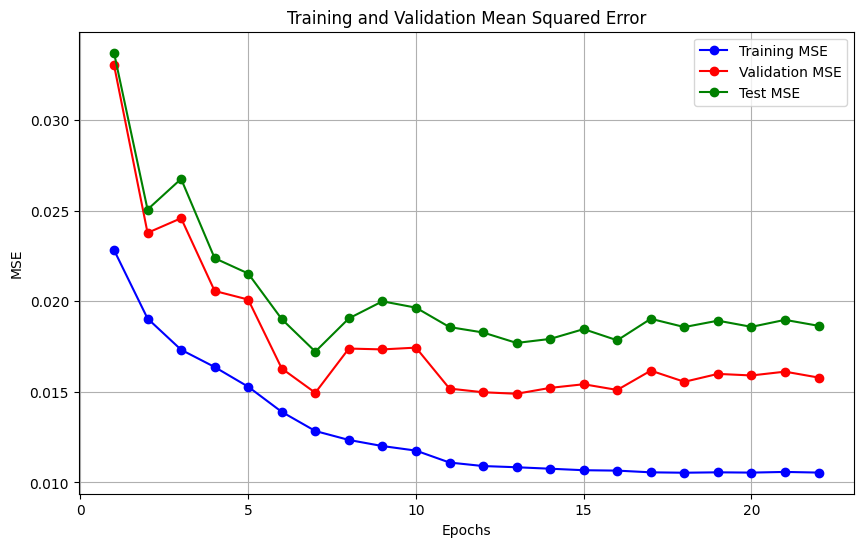

In [297]:


train_hist.extend(train_mse_history)

valid_hist.extend(val_mse_history)
test_hist.extend(test_mse_history)
epochs = range(1,len(train_hist)+1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_hist, 'bo-', label='Training MSE')
plt.plot(epochs, valid_hist, 'ro-', label='Validation MSE')
plt.plot(epochs, test_hist, 'go-', label='Test MSE')
plt.title('Training and Validation Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [255]:
model.eval()
with torch.no_grad():
    vec1, vec2, target = dataloader_test.dataset[2222]
    

    # print(vec1.size(),vec2.size(),target.size())
    vec1 , vec2 ,target = vec1.unsqueeze(0), vec2.unsqueeze(0), target.unsqueeze(0)
    # print(vec1.size(),vec2.size(),target.size())
    vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
    prediction = model(vec1, vec2)
    print(f"Predicted Closeness: {prediction.item()}, Actual Closeness: {target.item()}")

Predicted Closeness: 0.503044605255127, Actual Closeness: 0.635431706905365


In [169]:
torch.save(model.state_dict(), 'model_siamese.pth')

In [19]:
input_dim = len(columns_1)  # Assuming both vectors have the same number of features
model = SiameseNetwork(input_dim).to(device)
model.load_state_dict(torch.load('model_siamese.pth'))

<All keys matched successfully>

In [301]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
def test_model(model, dataloader, df_test, device):
    df = df_test.copy()
    model.eval()  # Set model to evaluation mode
    predictions = []
    targets = []
    with torch.no_grad():  # Disable gradient computation
        for vector1, vector2, target in tqdm(dataloader, desc="Testing"):
            # Move data to the specified device
            vector1 = vector1.to(device)
            vector2 = vector2.to(device)
            target = target.to(device)

            # Forward pass
            output = model(vector1, vector2)

            # Collect predictions and targets
            predictions.append(output.cpu().numpy())
            targets.append(target.cpu().numpy())

    # Concatenate all batches
    y_pred = np.vstack(predictions).flatten()
    y_true = np.vstack(targets).flatten()
    df["Predicted Closeness"] = y_pred
    df["absolute_error"] = np.abs(df["Closeness"] - df["Predicted Closeness"])
    mse = mean_squared_error(y_true, y_pred)
    print(f"Test MSE: {mse:.4f}")

    hue_order = sorted(df["Cross Reference Type"].unique())
    sns.histplot(df[df["Predicted Closeness"] <= 1], x='Predicted Closeness', hue='Cross Reference Type', bins=50, hue_order=hue_order)
    # plt.xlim(0, 1)
    plt.show()

    sns.kdeplot(df[df["Predicted Closeness"] <= 1], x='Predicted Closeness', hue='Cross Reference Type', fill=True, common_norm=False, hue_order=hue_order)
    # plt.xlim(0, 1)
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    cross_reference_types = df["Cross Reference Type"].unique()

    for ax, ctype in zip(axes.flatten(), cross_reference_types):
        sns.histplot(df[df["Cross Reference Type"] == ctype], x='Predicted Closeness', hue='Cross Reference Type', ax=ax)
        ax.set_title(f'Cross Reference Type: {ctype}')
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    sns.barplot(data=df, hue='Cross Reference Type', x='absolute_error')
    
    plt.show()
    return mse



(0.0, 1.0)

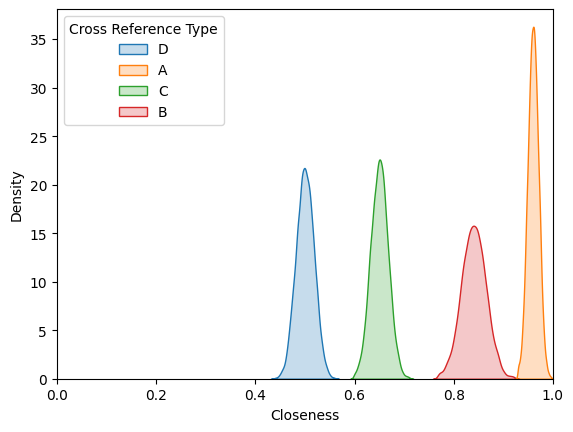

In [300]:
sns.kdeplot(test_df, x='Closeness', hue='Cross Reference Type',fill=True, common_norm=False)
plt.xlim(0, 1)

Testing:   0%|          | 0/1250 [00:00<?, ?it/s]

Testing: 100%|██████████| 1250/1250 [00:05<00:00, 244.04it/s]


Test MSE: 0.0186


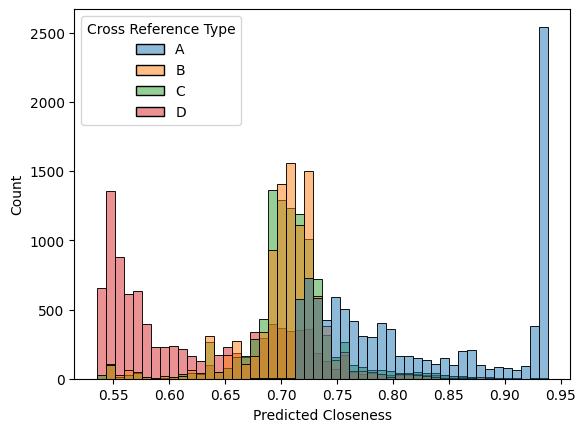

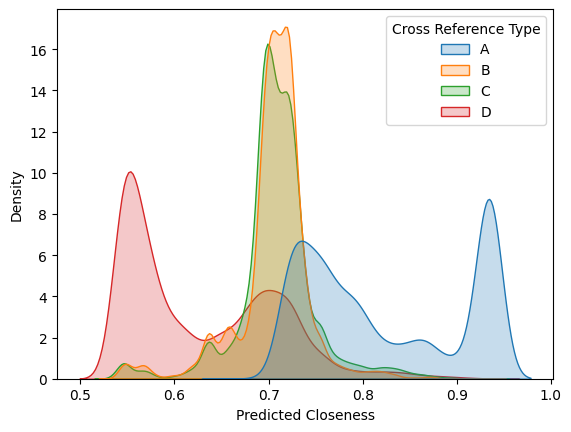

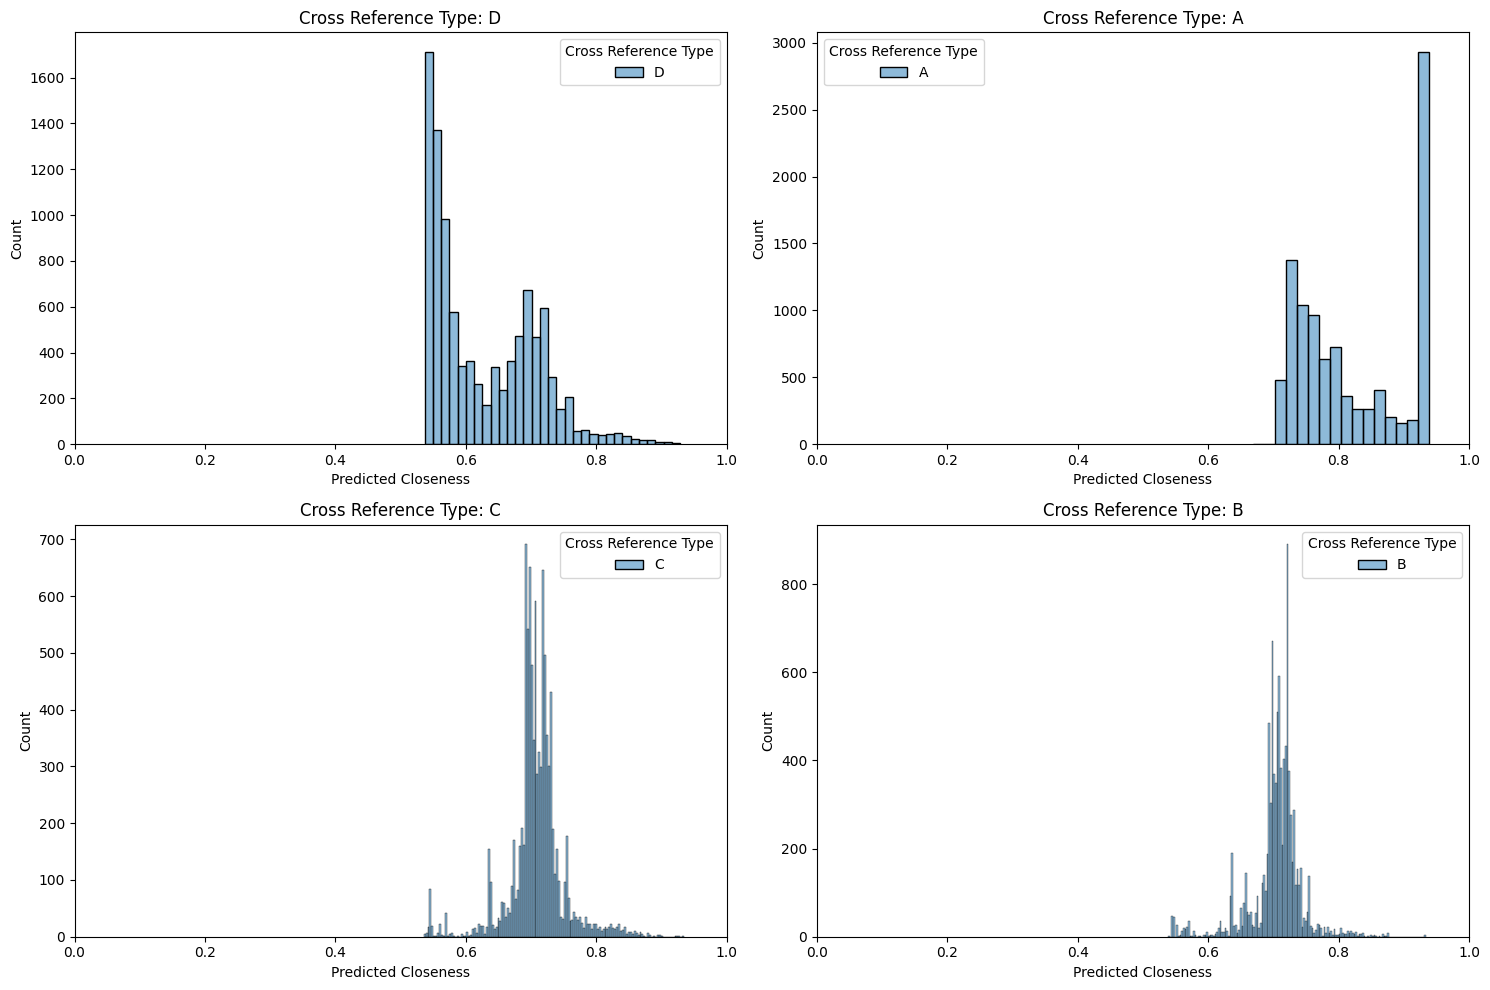

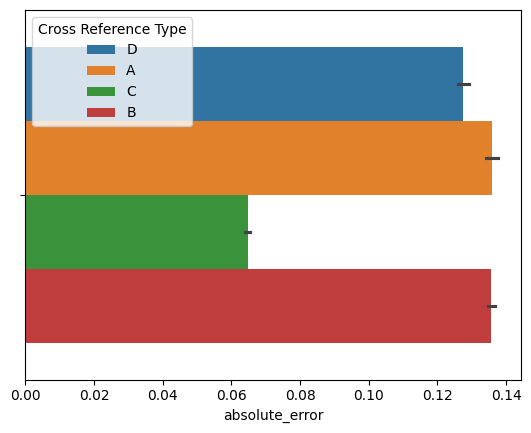

In [302]:
mse = test_model(model, dataloader_test, test_df, device)

In [31]:
model.eval()
vec1, vec2, target = next(iter(dataloader))
vec1, vec2, target = vec1.to(device), vec2.to(device), target.to(device)
prediction = model(vec1, vec2)
print(f"Predicted Closeness: {prediction[:5]}, Actual Closeness: {target[:5]}")

Predicted Closeness: tensor([[0.5446],
        [0.5446],
        [0.5446],
        [0.5446],
        [0.5446]], device='cuda:0', grad_fn=<SliceBackward0>), Actual Closeness: tensor([[0.9660],
        [0.9647],
        [0.9633],
        [0.9522],
        [0.9473]], device='cuda:0')
